# Model Training and Evaluation

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import iqr
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, make_scorer, accuracy_score
from sklearn.model_selection import cross_validate

import torch
import torch.nn as nn

import pickle
import os


## Base Models

The first set of implemented models will be based on the simplest preprocessing methods without any feature engineering. These models will act as a benchmark for all subsequent attempts. The set will include a K-Neighbors Classifier, Decision Tree, Gradient Boosting, Random Forest, Linear Discriminant Analysis, and Logistic Regression models. The models will be compared, and a feature importance plot will be plotted using the best-performing model. 

### Base Models with Iteratively Imputed Data

The models will first be implemented with the data imputed with the Iterative Imputer. The dataset is loaded below.

In [47]:
train_imputed_iterative = pd.read_pickle('../Data/Preprocessed/train_imputed_iterative.pkl')

In [48]:
# Splitting the data into features and response:
X = train_imputed_iterative.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_iterative['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

The models to be implemented are first defined inside a dictionary. A results list is instantiated to save the model score results. Since this is a classification problem, the metrics of interest will be *accuracy*, *precision* and *recall*. *Precision* can be viewed as the accuracy of the positive predictions, it can be calculated as follows:

$$precision = \frac{TP}{TP + FP},$$

where $TP$ is the number of true positives, and $FP$ is the number of false positives. This metric is usually reported alongside *recall*, also called *sensitivity* or the *true positive rate* (TPR). *Recall* is the ratio of positive instances that are correctly classified. *Recall* can be calculated as follows:

$$recall = \frac{TP}{TP + FN},$$

where $TP$ is the number of true positives and $FN$, the number of false negatives [(Aurelian Géron, 2023)](#ref-Geron2023).


K-Fold cross-validation (with 10 splits) is used to avoid overfitting. K=10 was chosen as it is a generally acceptable number for this method. The results from the cross-validation are stored in a pickle file for further use. 

In [49]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

    # Save the model to disk
    # model_pkl_file = '../Models/Imputation_Model_1/{}.pkl'.format(name)
    # with open(model_pkl_file, 'wb') as file:
        # pickle.dump(model, file)

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_1/results_iterative_model.pkl')


The results are now printed, and accuracy plots are presented for comparison purposes. 

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.943294
                             Precision  0.951660
                             Recall     0.948087
Gradient Boosting            Accuracy   0.942813
                             Precision  0.939234
                             Recall     0.961259
KNN                          Accuracy   0.925999
                             Precision  0.915855
                             Recall     0.957362
Linear Discriminant Analysis Accuracy   0.885490
                             Precision  0.900655
                             Recall     0.896834
Logistic Regression          Accuracy   0.888426
                             Precision  0.899925
                             Recall     0.903583
Random Forest                Accuracy   0.962754
                             Precision  0.955711
                             Recall     0.979645


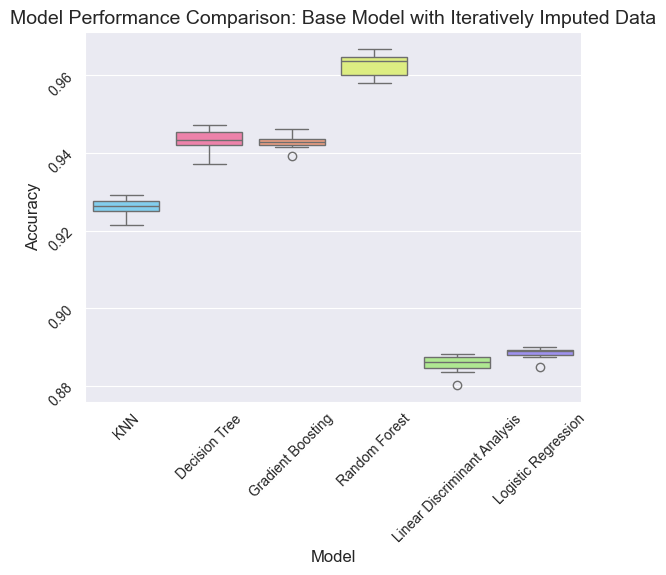

In [50]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_1/results_iterative_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with Iteratively Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

The plot above and the comparison data frame for the results clearly show that the Random Forrest model outperformed the others. It has achieved an accuracy of 0.9627, a precision of 0.9557 and a recall of 0.9796. These results are surprisingly high for a base model.

### Base Model with KNN Imputer 

The KNN-imputed data will now be imported for the next set of model comparisons. The same steps will be undertaken as in the previous implementation.

In [51]:
train_imputed_knn = pd.read_pickle('../Data/Preprocessed/train_imputed_knn.pkl')

In [52]:
# Splitting the data into features and response:
X = train_imputed_knn.drop(columns = 'Satisfaction', axis = 1)
y = train_imputed_knn['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [53]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

    # Save the model to disk
    # model_pkl_file = '../Models/Imputation_Model_2/{}.pkl'.format(name)
    # with open(model_pkl_file, 'wb') as file:
        # pickle.dump(model, file)

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_2/results_knn_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.944574
                             Precision  0.934158
                             Recall     0.938232
Gradient Boosting            Accuracy   0.942995
                             Precision  0.947188
                             Recall     0.919768
KNN                          Accuracy   0.924247
                             Precision  0.942093
                             Recall     0.879262
Linear Discriminant Analysis Accuracy   0.884220
                             Precision  0.865326
                             Recall     0.867871
Logistic Regression          Accuracy   0.887175
                             Precision  0.872630
                             Recall     0.866017
Random Forest                Accuracy   0.963822
                             Precision  0.974326
                             Recall     0.941348


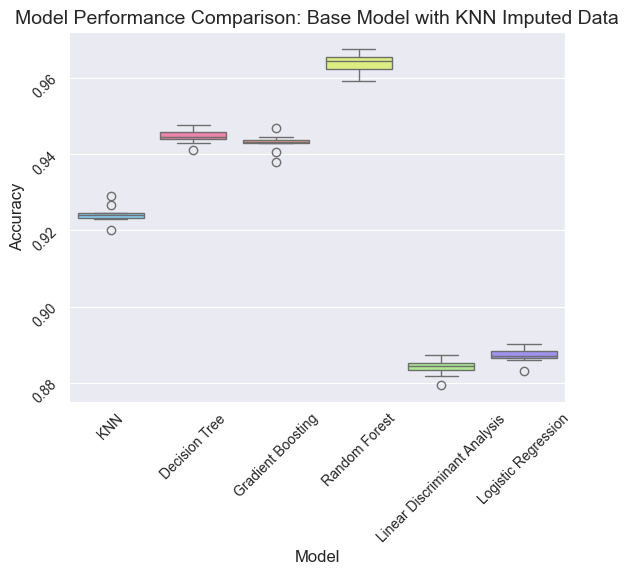

In [54]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_2/results_knn_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with KNN Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

Results with the KNN-imputed data are slightly better than those obtained with the Itertive Imputer. The Random Forrest algorithm obtains an accuracy score of approximately 0.9638, a precision of 0.9743, and a recall of 0.9413.

### Base Model with DropNa and Mode Imputation

Here, the data with the thrid imputation method will be imported. A reminder: entries with NaNs were dropped only for those features where the number of NaNs was less than the established threshold of 5% (of the data size). For all other features, the mode was used to impute the missing values. This imputation method assumes that the 'Non-Applicable' categories are irrelevant for response predictions.

In [55]:
# Importing the preprocessed data:
train_preprocessed_dropna_mode = pd.read_pickle('../Data/Preprocessed/train_preprocessed_dropna_mode.pkl')

In [56]:
# Splitting the data into features and response:
X = train_preprocessed_dropna_mode.drop(columns = 'Satisfaction', axis = 1)
y = train_preprocessed_dropna_mode['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [57]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

    # Save the model to disk
    # model_pkl_file = '../Models/Imputation_Model_3/{}.pkl'.format(name)
    # with open(model_pkl_file, 'wb') as file:
        # pickle.dump(model, file)

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_3/results_dropna_mode_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.945630
                             Precision  0.954313
                             Recall     0.951566
Gradient Boosting            Accuracy   0.944356
                             Precision  0.943362
                             Recall     0.961529
KNN                          Accuracy   0.937811
                             Precision  0.931738
                             Recall     0.963055
Linear Discriminant Analysis Accuracy   0.894912
                             Precision  0.912730
                             Recall     0.904835
Logistic Regression          Accuracy   0.898806
                             Precision  0.911469
                             Recall     0.913809
Random Forest                Accuracy   0.963919
                             Precision  0.957720
                             Recall     0.980927


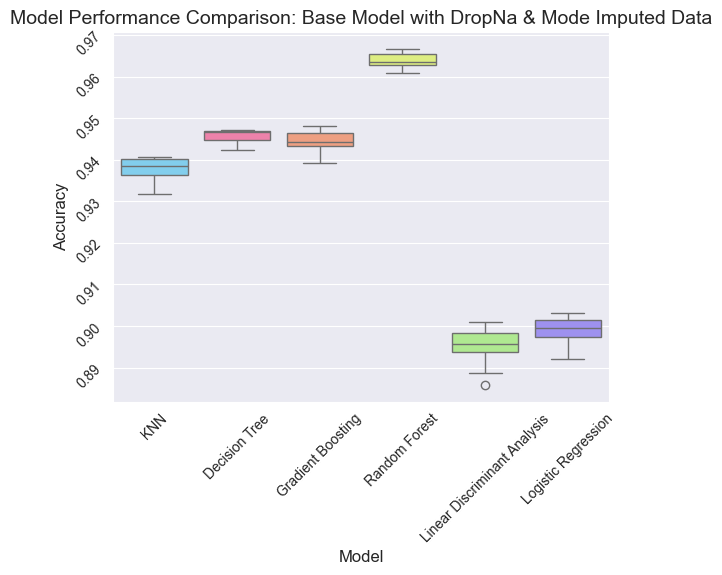

In [58]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_3/results_dropna_mode_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with DropNa & Mode Imputed Data', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

plt.show()

Again, the plot looks similar to the previous two. The Random Forrest results are slightly better than those of KNN. This model reached an accuracy of 0.9639, a precision of 0.9577, and a recall of 0.9809. This suggests that dropping the NaN entries has slightly helped the model performance. 

### Base Model with Non-Applicable Category

The last model comparison will be performed using the data set where the 'Non-Applicable' entries were given a separate category in the data. The missing values for the 'Arrival Delay in Minutes' feature were computed using the Iterative Imputer, with an `initial_strategy` set to the 'mean'. 

In [61]:
non_applicable_imputed = pd.read_pickle('../Data/Preprocessed/non_applicable_imputed.pkl')

In [62]:
# Splitting the data into features and response:
X = non_applicable_imputed.drop(columns = 'Satisfaction', axis = 1)
y = non_applicable_imputed['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [63]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

    # Save the model to disk
    # model_pkl_file = '../Models/Imputation_Model_4/{}.pkl'.format(name)
    # with open(model_pkl_file, 'wb') as file:
        # pickle.dump(model, file)

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Imputation_Model_4/results_nonapplicable_mode_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.945546
                             Precision  0.953385
                             Recall     0.950359
Gradient Boosting            Accuracy   0.943987
                             Precision  0.941742
                             Recall     0.960561
KNN                          Accuracy   0.928001
                             Precision  0.914205
                             Recall     0.963335
Linear Discriminant Analysis Accuracy   0.872363
                             Precision  0.877534
                             Recall     0.900406
Logistic Regression          Accuracy   0.875616
                             Precision  0.878800
                             Recall     0.905350
Random Forest                Accuracy   0.965179
                             Precision  0.958047
                             Recall     0.981519


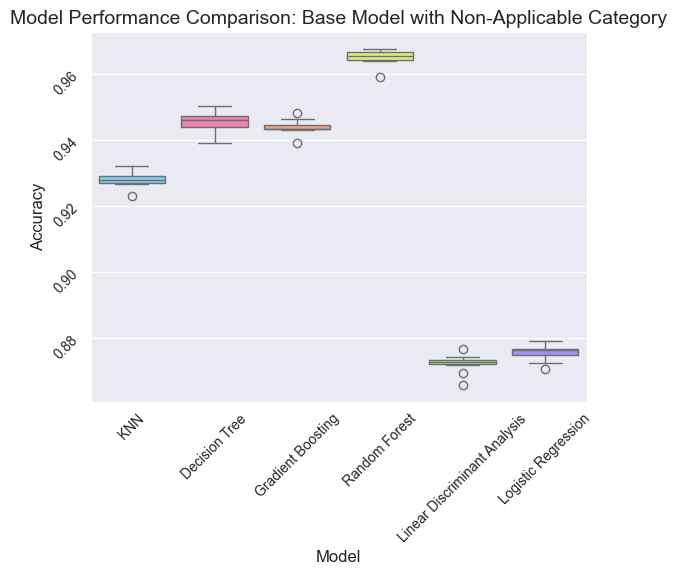

In [64]:
# Loading the results:
results_long = pd.read_pickle('../Models/Imputation_Model_4/results_nonapplicable_mode_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Base Model with Non-Applicable Category', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

The comparison plot looks similar to all the other attempts. The Random Forrest algorithm has achieved an accuracy of 0.9652, a precision of 0.9580 and a recall of 0.9815. The results are slightly better than with the other data sets.

## Feature Engineering

Two attempts will be made with feature engineering, before proceeding to hyper-parameter tuning of the best performing model. The data for these models has been preprocessed in the `feature_engineering` notebook. 

### Feature Selection Model

In the first implementation, a dataset will be used that only includes a subset of the data. By eliminating features which do not have any impact on the response the model could potentially improve its predictive efficiency and accuracy. 

In [65]:
# Importing the preprocessed data:
train_fs = pd.read_pickle('../Data/Feature_Selection/train_fs.pkl')

In [66]:
# Splitting the data into features and response:
X = train_fs.drop(columns = 'Satisfaction', axis = 1)
y = train_fs['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [67]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

    # Save the model to disk
    # model_pkl_file = '../Models/Model_fs/{}.pkl'.format(name)
    # with open(model_pkl_file, 'wb') as file:
        # pickle.dump(model, file)

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Model_fs/results_fs_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.942081
                             Precision  0.950163
                             Recall     0.947460
Gradient Boosting            Accuracy   0.940397
                             Precision  0.937040
                             Recall     0.959252
KNN                          Accuracy   0.930657
                             Precision  0.915842
                             Recall     0.966426
Linear Discriminant Analysis Accuracy   0.870140
                             Precision  0.875545
                             Recall     0.898547
Logistic Regression          Accuracy   0.872825
                             Precision  0.876719
                             Recall     0.902455
Random Forest                Accuracy   0.960002
                             Precision  0.953104
                             Recall     0.977502


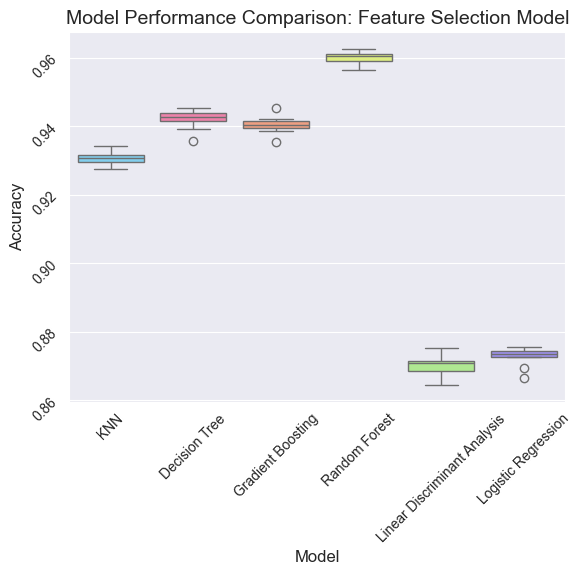

In [68]:
# Loading the results:
results_long = pd.read_pickle('../Models/Model_fs/results_fs_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Feature Selection Model', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

The plots and results seem are worse when feature selection is performed. It seems like too much information is lost when features are excluded.

### Feature Extraction Model

The same models will be tested with two extra aggregated features, `Overall Satisfaction Score` and `Premium Service`. The relevant dataset is imported.

In [23]:
# Importing the preprocessed data:
train_oss = pd.read_pickle('../Data/Feature_Extraction/train_oss.pkl')

In [24]:
# Splitting the data into features and response:
X = train_oss.drop(columns = 'Satisfaction', axis = 1)
y = train_oss['Satisfaction']

# Scaling the data:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
# Defining the four models:
models = {'KNN': KNeighborsClassifier(),
          'Decision Tree': DecisionTreeClassifier(),
          'Gradient Boosting': GradientBoostingClassifier(),
          'Random Forest': RandomForestClassifier(),
          'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
          'Logistic Regression': LogisticRegression()}

# Storing the results:
# results = []

# Defining the scoring metrics:
# scoring = {'accuracy': make_scorer(accuracy_score),
           # 'precision': make_scorer(precision_score),
           # 'recall': make_scorer(recall_score)}

# Performing the cross validation:
# for name, model in models.items():
    # kf = KFold(n_splits=10, random_state=42, shuffle=True)
    # cv_results = cross_validate(model, X_scaled, y, cv=kf, scoring = scoring, return_train_score = False)
    
    # Saving the results:
    # results.append({
        # 'Model': name,
        # 'Accuracy': cv_results['test_accuracy'],
        # 'Precision': cv_results['test_precision'],
        # 'Recall': cv_results['test_recall']
    # })

    # Save the model to disk
    model_pkl_file = '../Models/Model_fe/{}.pkl'.format(name)
    with open(model_pkl_file, 'wb') as file:
        pickle.dump(model, file)

# Creating a long-format DataFrame:
# rows = []

# for model_dict in results:
    # model_name = model_dict.pop('Model')
    # for metric_name, metric_values in model_dict.items():
        # for value in metric_values:
            # rows.append({'Model': model_name, 'Metric': metric_name, 'Value': value})

# results_long = pd.DataFrame(rows)

# Saving results:
# results_long.to_pickle('../Models/Model_fe/results_fe_model.pkl')

                                           Value
Model                        Metric             
Decision Tree                Accuracy   0.945989
                             Precision  0.953681
                             Recall     0.950847
Gradient Boosting            Accuracy   0.944073
                             Precision  0.941707
                             Recall     0.960767
KNN                          Accuracy   0.926634
                             Precision  0.912392
                             Recall     0.962999
Linear Discriminant Analysis Accuracy   0.871160
                             Precision  0.876867
                             Recall     0.898839
Logistic Regression          Accuracy   0.875106
                             Precision  0.878668
                             Recall     0.904479
Random Forest                Accuracy   0.964159
                             Precision  0.957149
                             Recall     0.980632


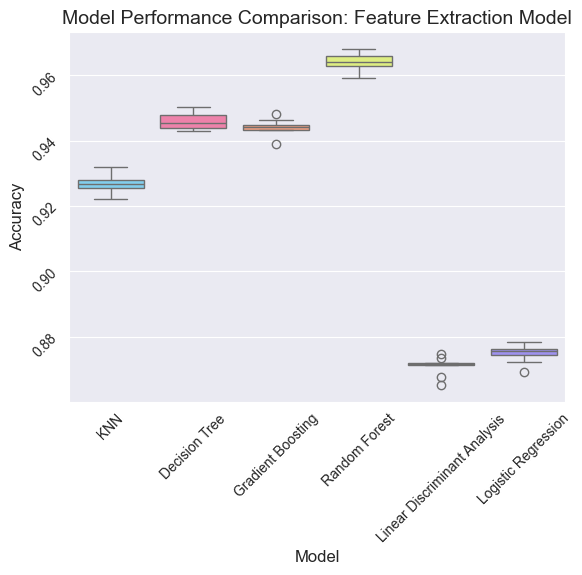

In [26]:
# Loading the results:
results_long = pd.read_pickle('../Models/Model_fe/results_fe_model.pkl')

# Formatting the results for printing:
results = results_long.groupby(['Model', 'Metric']).mean()
results = pd.DataFrame(results)
print(results)

# Formatting data for multiple boxplots plot:
results_boxplot = results_long[results_long['Metric'] == 'Accuracy'].drop('Metric', axis = 1)

# Plotting the boxplots:
sns.set_style('darkgrid')
ax = sns.boxplot(x='Model', y='Value', hue='Model', data=results_boxplot, palette = ['#70D6FF', '#FF70A6', '#FF9770', '#E9FF70', '#AAF683', '#9381FF'])

# Customizing the plots:
ax.set_title('Model Performance Comparison: Feature Extraction Model', fontsize = 14)
ax.set_xlabel('Model', fontsize = 12)
ax.set_ylabel('Accuracy', fontsize = 12)
ax.tick_params(axis='both', labelsize = 10, rotation = 45)

This model has also achieved relatively good results. The Random Forest algorithm has achieved an accuracy score of 0.9642, a precision of 0.9571 and a recall of 0.9806. 

### Feature Importance Plot

The best performing model up to now has been the 'Base Model with a Non-Applicable Category'. This model will be used to plot a feature importance plot. This plot shows the features which are most important in driving customer satisfaction outcomes.

In [29]:
# Renaming models for plotting:
models = {'knn': KNeighborsClassifier(),
          'decision_tree': DecisionTreeClassifier(),
          'gradient_boosting': GradientBoostingClassifier(),
          'random_forest': RandomForestClassifier()}

# Dictionary to store loaded models:
loaded_models = {}

# Loading the saved models:
for name in models.keys():
    model_pkl_file = '../Models/Imputation_Model_4/{}.pkl'.format(name)
    with open(model_pkl_file, 'rb') as file: 
        loaded_models[name] = pickle.load(file) 

# Plotting feature importance using random_forest:
if 'random_forest' in loaded_models:
    model_rf = loaded_models['random_forest']
    importance = pd.Series(model_rf.feature_importances_, index=X_train.columns)
    colors = list(reversed(sns.color_palette("Blues", len(importance))))
    ax = importance.sort_values(ascending=False).plot(kind='bar', color=colors, figsize=(10, 6))
    
    # Customising the plot:
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Importance', fontsize=12)
    ax.set_title('Feature Importance using the Random Forest Model: Feature Extraction Model', fontsize=14)
    ax.tick_params(axis='both', labelsize=10)
    plt.show()
else:
    print("Random Forest model is not loaded.")

AttributeError: 'float' object has no attribute 'feature_importances_'

## Deep Neural Network

Through simple feature engineering it wa snot possible to improve the model's performance substantially. The next model to be implemented will be a deep neural network using PyTorch. These machine learning models can perform feature engineering with raw data. 

In [31]:
non_applicable_imputed = pd.read_pickle('../Data/Preprocessed/non_applicable_imputed.pkl')

In [32]:
non_applicable_imputed

,id,Age,Class,Flight Distance,Inflight Wifi Service,Departure/Arrival Time Convenient,Ease of Online Booking,Gate Location,Food and Drink,Online Boarding,...,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Satisfaction,Dummy_Female,Dummy_Male,Dummy_Disloyal customer,Dummy_Loyal customer,Dummy_Business travel,Dummy_Personal travel
0,70172.0,13.0,2.0,460.0,3.0,4.0,3.0,1.0,5.0,3.0,...,5.0,25.0,18.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,5047.0,25.0,3.0,235.0,3.0,2.0,3.0,3.0,1.0,3.0,...,1.0,1.0,6.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
2,110028.0,26.0,3.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,...,5.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0
3,24026.0,25.0,3.0,562.0,2.0,5.0,5.0,5.0,2.0,2.0,...,2.0,11.0,9.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
4,119299.0,61.0,3.0,214.0,3.0,3.0,3.0,3.0,4.0,5.0,...,3.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171.0,23.0,1.0,192.0,2.0,1.0,2.0,3.0,2.0,2.0,...,2.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
103900,73097.0,49.0,3.0,2347.0,4.0,4.0,4.0,4.0,2.0,4.0,...,4.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0
103901,68825.0,30.0,3.0,1995.0,1.0,1.0,1.0,3.0,4.0,1.0,...,4.0,7.0,14.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
103902,54173.0,22.0,1.0,1000.0,1.0,1.0,1.0,5.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


## References

1. <a id="ref-Geron2023"></a>Aurelian Géron, Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow (3rd Edition), O'Reilly Media Inc, 20 January 2023.